
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [27]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


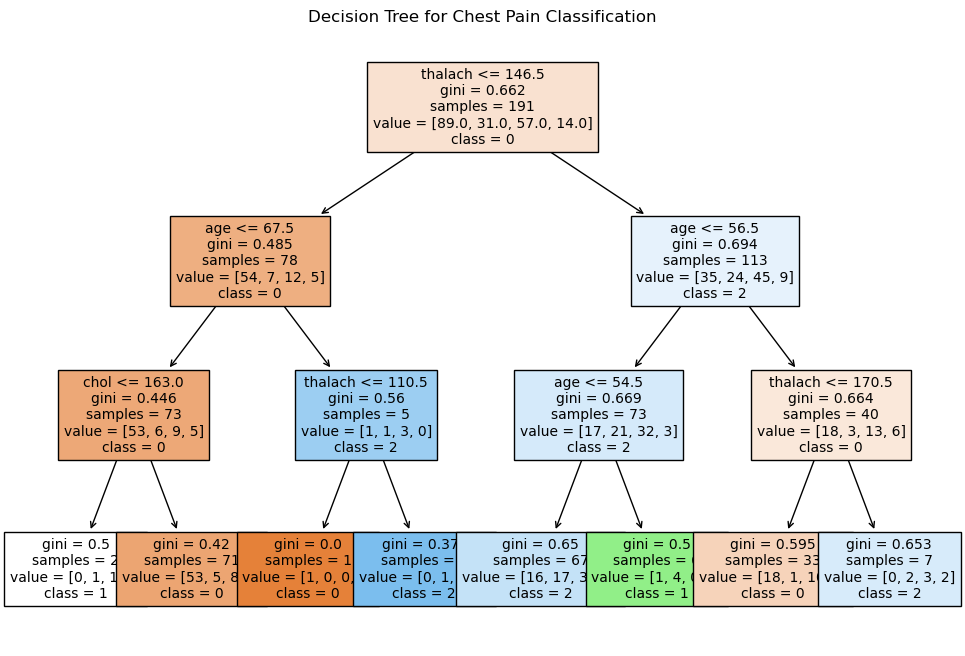

First Split Feature: thalach
Threshold: 146.5
KNN Accuracy: 0.48
Decision Tree Accuracy: 0.50
LDA Accuracy: 0.49
First Split Feature: thalach
Threshold: 146.5
KNN Accuracy: 0.48
Decision Tree Accuracy: 0.50
LDA Accuracy: 0.49


In [3]:
# Define predictors and target for multiclass classification
X = ha.drop(columns=["cp", "output"])
y = ha["cp"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## KNN Model
knn = KNeighborsClassifier(n_neighbors=5)  # Using 5 neighbors as default
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

## Decision Tree Model
dt = DecisionTreeClassifier(max_depth=3, random_state=42)  # Limit depth for interpretability
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=X.columns, class_names=["0", "1", "2", "3"], filled=True, fontsize=10)
plt.title("Decision Tree for Chest Pain Classification")
plt.show()

# Interpret the first couple of splits
print("First Split Feature:", X.columns[dt.tree_.feature[0]])
print("Threshold:", dt.tree_.threshold[0])

## LDA Model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
lda_accuracy = accuracy_score(y_test, y_pred_lda)

# Print accuracies
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print(f"LDA Accuracy: {lda_accuracy:.2f}")


The first split in the decision tree uses thalach (maximum heart rate during exercise) with a threshold of 146.5. Patients with a heart rate below this threshold tend to belong to class 0 (asymptomatic), while those with higher heart rates are split further, often leaning toward class 2. The second split on the left branch uses age with a threshold of 67.5. Younger patients (age < 67.5) are more likely to remain in class 0, while older patients are split further based on cholesterol levels. This shows that both heart rate and age play a key role in predicting chest pain type, with heart rate being the most influential feature.

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [28]:
# Create binary columns for chest pain types
ha["cp_bin_0"] = (ha["cp"] == 0).astype(int)
ha["cp_bin_1"] = (ha["cp"] == 1).astype(int)
ha["cp_bin_2"] = (ha["cp"] == 2).astype(int)
ha["cp_bin_3"] = (ha["cp"] == 3).astype(int)

In [32]:
ha.head(2)

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_bin_0,cp_bin_1,cp_bin_2,cp_bin_3
0,63,1,3,145,233,0,150,1,0,0,0,1
1,37,1,2,130,250,1,187,1,0,0,1,0


In [31]:

# function to train logistic regression and evaluate mean F1 score
def evaluate_logistic_cv(df, target_var, drop_columns):
    """
    Fits a logistic regression model using cross-validation and computes the F1-macro score.
    
    Parameters:
    - df: Input DataFrame containing features and target variable.
    - target_var: The column to be used as the target for logistic regression.
    - drop_columns: Columns to exclude from the feature set.
    
    Returns:
    - None (prints the mean F1 score)
    """
    # predictors and target
    y = df[target_var]
    X = df.drop(columns=drop_columns, axis=1)
    
    # preprocessing pipeline
    preprocessing_steps = ColumnTransformer(
        transformers=[
            ("encode", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include=object))
        ],
        remainder="passthrough"
    )
    
    # logistic regression pipeline
    logistic_pipeline = Pipeline([
        ("preprocessing", preprocessing_steps),
        ("logistic", LogisticRegression(max_iter=200, random_state=0))
    ])
    
    # 5 fold cross val + f1 score
    f1_scores = cross_val_score(logistic_pipeline, X, y, cv=5, scoring="f1_macro")
    avg_f1 = f1_scores.mean()
    print(f"Mean F1-macro score for {target_var}: {avg_f1:.4f}")

# target variables and columns to exclude
binary_targets = ["cp_bin_3", "cp_bin_2", "cp_bin_1", "cp_bin_0"]
columns_to_exclude = binary_targets + ["cp"]

# use the function
for target in binary_targets:
    evaluate_logistic_cv(ha, target, columns_to_exclude)


Mean F1-macro score for cp_bin_3: 0.4800
Mean F1-macro score for cp_bin_2: 0.4349
Mean F1-macro score for cp_bin_1: 0.4528
Mean F1-macro score for cp_bin_0: 0.6616
Mean F1-macro score for cp_bin_3: 0.4800
Mean F1-macro score for cp_bin_2: 0.4349
Mean F1-macro score for cp_bin_1: 0.4528
Mean F1-macro score for cp_bin_0: 0.6616


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The OvR was best at distinguishing the category 0, shown by it having the highest f1 value.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [34]:
# Ensure binary columns are dropped (if they exist)
ha = ha.drop(["cp_bin_3", "cp_bin_2", "cp_bin_1", "cp_bin_0"], axis=1, errors="ignore")

def calculate_roc_auc(data, category_to_compare):
    """
    Filters the dataset to include only cp=0 and the specified comparison category,
    trains a Logistic Regression model, and calculates the mean ROC-AUC using cross-validation.

    Parameters:
    - data: DataFrame containing the dataset.
    - category_to_compare: Chest pain category to compare with cp=0.

    Returns:
    - Mean ROC-AUC score for the comparison.
    """
    # Filter data for cp=0 and the target comparison category
    filtered_data = data[data["cp"].isin([0, category_to_compare])]

    # Define predictors and target
    X = filtered_data.drop(columns=["cp"])
    y = filtered_data["cp"]

    # Define preprocessing and pipeline
    preprocessing = ColumnTransformer(
        transformers=[
            ("categorical", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include="object"))
        ],
        remainder="passthrough"
    )

    logistic_pipeline = Pipeline([
        ("preprocessor", preprocessing),
        ("logistic_model", LogisticRegression(max_iter=200, random_state=42))
    ])

    # Perform 5-fold cross-validation and calculate ROC-AUC
    roc_auc_scores = cross_val_score(logistic_pipeline, X, y, cv=5, scoring="roc_auc")
    return roc_auc_scores.mean()

# Calculate ROC-AUC for each comparison
roc_auc_0_vs_1 = calculate_roc_auc(ha, 1)
roc_auc_0_vs_2 = calculate_roc_auc(ha, 2)
roc_auc_0_vs_3 = calculate_roc_auc(ha, 3)

# Print results
print(f"ROC-AUC for cp=0 vs cp=1: {roc_auc_0_vs_1:.4f}")
print(f"ROC-AUC for cp=0 vs cp=2: {roc_auc_0_vs_2:.4f}")
print(f"ROC-AUC for cp=0 vs cp=3: {roc_auc_0_vs_3:.4f}")

# Determine the best comparison
roc_auc_results = {"0_vs_1": roc_auc_0_vs_1, "0_vs_2": roc_auc_0_vs_2, "0_vs_3": roc_auc_0_vs_3}
best_comparison = max(roc_auc_results, key=roc_auc_results.get)
print(f"\nThe OvO approach performed best for: {best_comparison} with ROC-AUC = {roc_auc_results[best_comparison]:.4f}")


ROC-AUC for cp=0 vs cp=1: 0.8353
ROC-AUC for cp=0 vs cp=2: 0.7486
ROC-AUC for cp=0 vs cp=3: 0.7296

The OvO approach performed best for: 0_vs_1 with ROC-AUC = 0.8353
ROC-AUC for cp=0 vs cp=1: 0.8353
ROC-AUC for cp=0 vs cp=2: 0.7486
ROC-AUC for cp=0 vs cp=3: 0.7296

The OvO approach performed best for: 0_vs_1 with ROC-AUC = 0.8353
